## Import Dependencies

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

## Load and Explore Data

In [2]:
import pickle

# Load the pickle file
with open('data/train_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Access images and labels
images = data['images']
labels = data['labels']

In [3]:
images.shape

(1080, 28, 28, 3)

In [19]:
import numpy as np

def check_class_distribution_safe(labels):
    """
    Robustly checks class distribution, handling (1, N) integer arrays correctly.
    """
    labels = np.array(labels) # Ensure it's a numpy array
    
    # 1. flatten() solves the (1, N) row vector issue immediately
    # If it's already 1D, this does nothing.
    labels_flat = labels.flatten()
    
    # 2. Check if it looks like One-Hot Encoding (OHE) or Integers
    # If the max value is 1, it might be OHE (unless it's binary classification 0/1)
    # But if max value > 1 (e.g., class 4), it is definitely Integer labels.
    if labels_flat.max() > 1:
        # It contains integers like 0, 2, 3, 4 -> Use as is
        y_integers = labels_flat
    else:
        # It's likely One-Hot Encoded (0s and 1s only). We need argmax.
        # We must go back to the original shape to know which axis to crush.
        if labels.ndim > 1:
            if labels.shape[0] < labels.shape[1]: 
                # Shape (Classes, Samples) -> Argmax axis 0
                y_integers = np.argmax(labels, axis=0)
            else:
                # Shape (Samples, Classes) -> Argmax axis 1
                y_integers = np.argmax(labels, axis=1)
        else:
            y_integers = labels_flat

    # 3. Calculate Counts
    unique_classes, counts = np.unique(y_integers, return_counts=True)
    total_samples = len(y_integers)
    
    # 4. Print Report
    print(f"--- Class Distribution Report ---")
    print(f"Array Shape: {labels.shape}")
    print(f"Total Images: {total_samples}")
    print("-" * 30)
    
    for cls, count in zip(unique_classes, counts):
        percentage = (count / total_samples) * 100
        print(f"Class {cls}: {count:<5} images ({percentage:.2f}%)")
    print("-" * 30)

# --- USAGE ---
check_class_distribution_safe(labels)

--- Class Distribution Report ---
Array Shape: (1016, 1)
Total Images: 1016
------------------------------
Class 0: 473   images (46.56%)
Class 1: 116   images (11.42%)
Class 2: 189   images (18.60%)
Class 3: 178   images (17.52%)
Class 4: 60    images (5.91%)
------------------------------


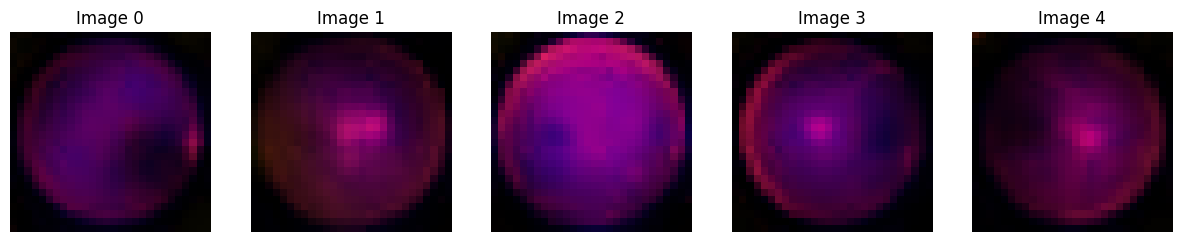

In [232]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 5 columns
# figsize=(width, height) controls how big the overall image is
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    # Select the image
    img_data = images[i]
    
    # Optional: Normalize if your data is float 0-255
    # img_data = images[i] / 255.0 
    
    # Plot on the specific axis (subplot)
    axes[i].imshow(img_data)
    axes[i].axis('off')  # Hide the axis numbers for a cleaner look
    axes[i].set_title(f"Image {i}")

plt.show()

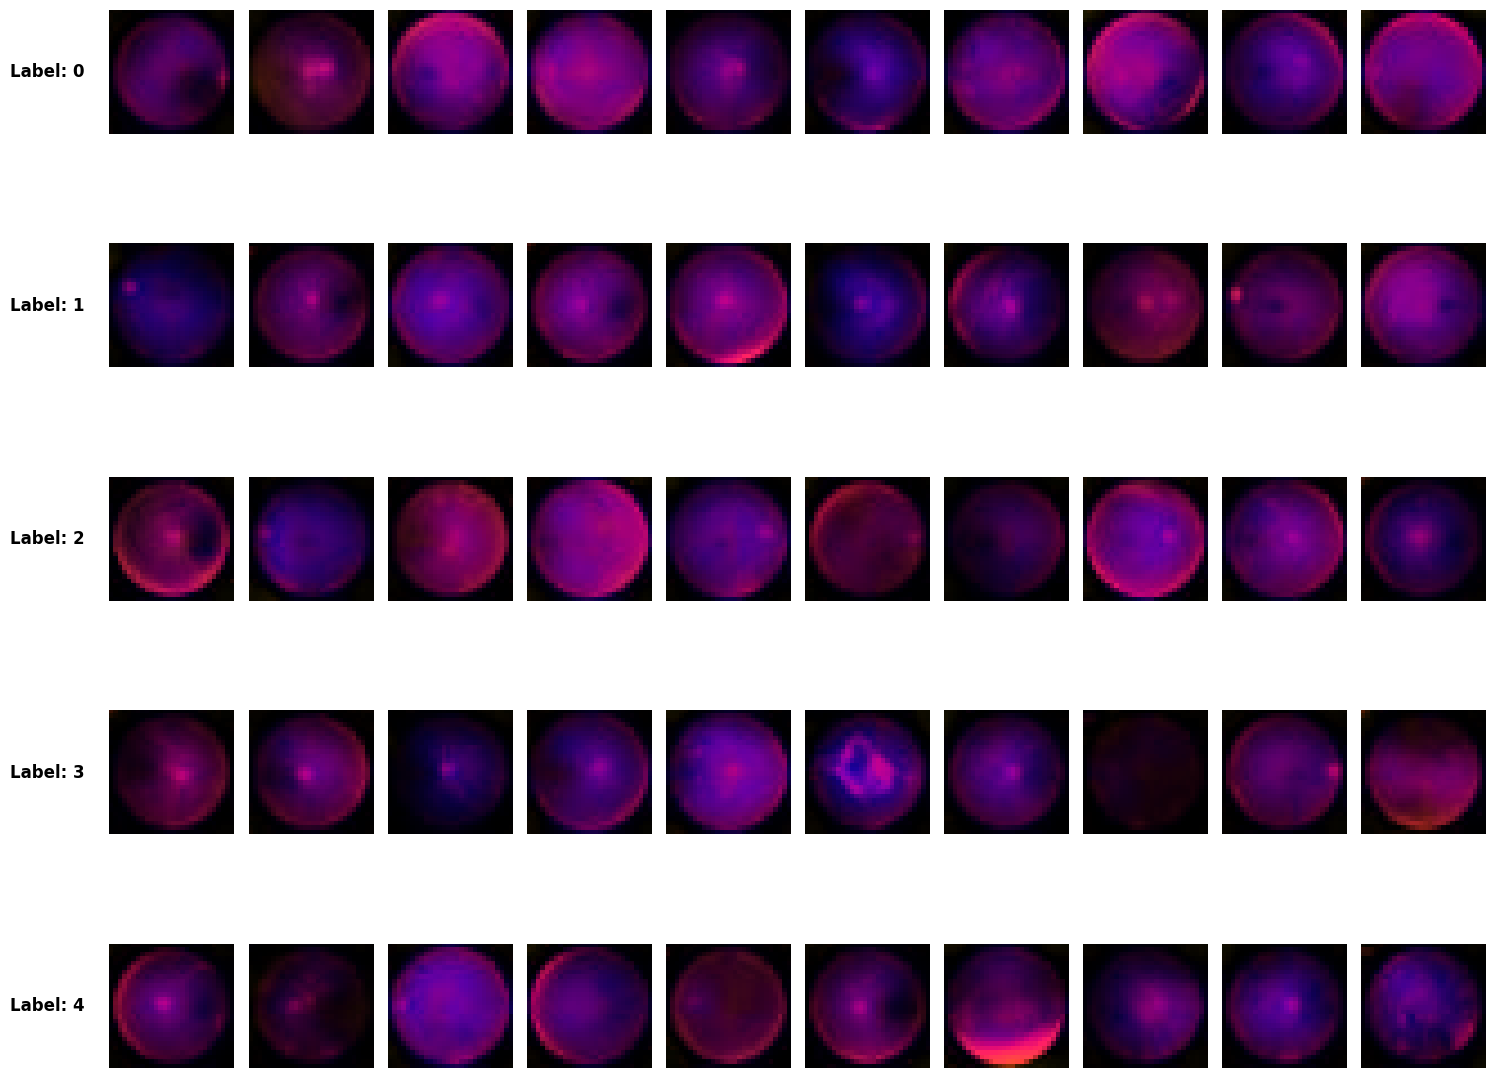

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Get unique classes
unique_labels = np.unique(labels)
num_classes = len(unique_labels)

# 2. Create a big figure: Rows = Number of Classes, Cols = 10 samples
fig, axes = plt.subplots(num_classes, 10, figsize=(15, 2.5 * num_classes))

# 3. Loop through each class and plot
for i, current_label in enumerate(unique_labels):
    # Find indices of all images with this label
    # We use [0] because np.where returns a tuple
    idxs = np.where(labels == current_label)[0]
    
    # Take the first 10 (or fewer if less than 10 exist)
    sample_idxs = idxs[:10]
    
    for j in range(10):
        ax = axes[i, j] if num_classes > 1 else axes[j]
        
        if j < len(sample_idxs):
            # Get the image
            img_idx = sample_idxs[j]
            img = images[img_idx]
            
            # Normalize if necessary (fixes white image issue)
            if img.dtype.kind == 'f' and img.max() > 1:
                img = img / 255.0
                
            ax.imshow(img)
        
        # Clean up axes
        ax.axis('off')
        
        # Add label text only on the first column of the row
        if j == 0:
            ax.text(-0.2, 0.5, f"Label: {current_label}", 
                    transform=ax.transAxes, 
                    fontsize=12, va='center', ha='right', fontweight='bold')

plt.tight_layout()
plt.show()

In [4]:
import numpy as np
np.unique(labels)

array([0, 1, 2, 3, 4], dtype=uint8)


--- Search for Intensity 10 ---
Target Range: [5.00, 15.00]


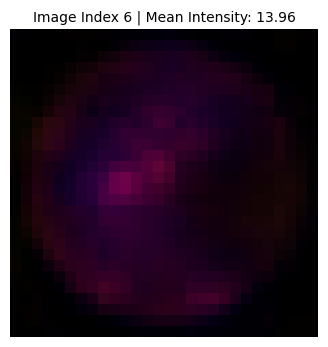

RESULT: Visualizing the first match found at index 6.


In [189]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_first_image_by_intensity(
    images, 
    target_intensity, 
    tolerance=5
):
    """
    Finds and visualizes the first image in the array whose mean intensity 
    falls within the specified range [target_intensity - tolerance, target_intensity + tolerance].
    
    The function automatically detects if the input is grayscale (N, H, W, 1) or color (N, H, W, 3).

    :param images: Image array (N, H, W, C), assumed to be 0-255 scaled.
    :param target_intensity: The central intensity value to target (0-255).
    :param tolerance: Half the width of the intensity band (e.g., 5).
    """
    
    # Check if the array is 4-dimensional (N, H, W, C)
    if images.ndim != 4:
        print("Error: Input array 'images' must be 4-dimensional (N, H, W, C).")
        return
        
    # Determine plotting structure based on channel count
    channel_count = images.shape[-1]
    is_grayscale = (channel_count == 1)
    
    # 1. Calculate the mean intensity for each image across all spatial/channel axes
    # The result is a 1D array of shape (N,)
    # Uses axis=(-3, -2, -1) to target the H, W, and C axes efficiently.
    mean_intensities = np.mean(images, axis=(-3, -2, -1))

    # 2. Define the intensity bounds
    lower_bound = target_intensity - tolerance
    upper_bound = target_intensity + tolerance
    
    # 3. Create a boolean mask: True for images within the range
    valid_mask = (mean_intensities >= lower_bound) & (mean_intensities <= upper_bound)
    
    # 4. Find the index of the first match
    match_indices = np.where(valid_mask)[0]
    
    print(f"\n--- Search for Intensity {target_intensity} ---")
    print(f"Target Range: [{lower_bound:.2f}, {upper_bound:.2f}]")
    
    if len(match_indices) == 0:
        print("RESULT: No image found in the specified range.")
        return

    # Get the index of the very first matching image
    first_index = match_indices[0]
    first_image = images[first_index]
    actual_mean = mean_intensities[first_index]
    
    # --- 5. Plot the Single Image ---
    
    plt.figure(figsize=(4, 4))
    
    if is_grayscale:
        # Squeeze removes the redundant channel dimension (H, W, 1) -> (H, W) for plotting
        image_to_plot = np.squeeze(first_image, axis=-1)
        # Use cmap='gray' for proper grayscale display
        plt.imshow(image_to_plot, cmap='gray', vmin=0, vmax=255)
    else:
        # Assumes color (H, W, 3). Converts to uint8 for correct color rendering.
        plt.imshow(first_image.astype(np.uint8)) 

    plt.title(f"Image Index {first_index} | Mean Intensity: {actual_mean:.2f}", fontsize=10)
    plt.axis('off')
    plt.show()
    
    print(f"RESULT: Visualizing the first match found at index {first_index}.")

# --- INTENDED USAGE EXAMPLE (Assuming you have an array named 'images') ---
visualize_first_image_by_intensity(images, target_intensity=10, tolerance=5)

In [4]:
def one_hot_encode(Y_sparse, num_classes): #we have 5 classes: 0,1,2,3,4
    """
    Converts a sparse label vector (Y_sparse) into a one-hot encoded matrix.

    :param Y_sparse: 1D array of integer labels (e.g., [0, 1, 2, 0])
    :param num_classes: Total number of unique classes (K)
    :return: 2D NumPy array in shape (K, M) for the WX convention
    """
    # 1. Create the identity matrix (K, K)
    # The identity matrix (np.eye(K)) acts as a lookup table.
    # np.eye(3) -> [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

    # 2. Use sparse labels as indices
    # This selects the appropriate row from the identity matrix for each label.
    one_hot_matrix = np.eye(num_classes)[Y_sparse] # Shape: (M, K)

    # 3. Transpose for the WX convention
    # Convert (Samples, Classes) to (Classes, Samples) -> (K, M)
    return one_hot_matrix.T


--- Search for Intensity 15 ---
Target Range: [14.00, 16.00]


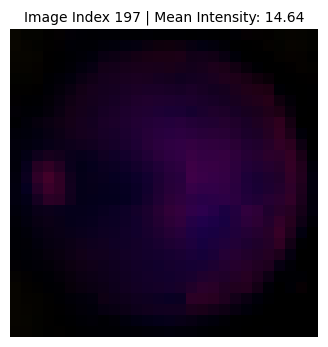

RESULT: Visualizing the first match found at index 197.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_first_image_by_intensity(
    images, 
    target_intensity, 
    tolerance=1
):
    """
    Finds and visualizes the first image in the array whose mean intensity 
    falls within the specified range [target_intensity - tolerance, target_intensity + tolerance].
    
    The function automatically detects if the input is grayscale (N, H, W, 1) or color (N, H, W, 3).

    :param images: Image array (N, H, W, C), assumed to be 0-255 scaled.
    :param target_intensity: The central intensity value to target (0-255).
    :param tolerance: Half the width of the intensity band (e.g., 5).
    """
    
    # Check if the array is 4-dimensional (N, H, W, C)
    if images.ndim != 4:
        print("Error: Input array 'images' must be 4-dimensional (N, H, W, C).")
        return
        
    # Determine plotting structure based on channel count
    channel_count = images.shape[-1]
    is_grayscale = (channel_count == 1)
    
    # 1. Calculate the mean intensity for each image across all spatial/channel axes
    # The result is a 1D array of shape (N,)
    # Uses axis=(-3, -2, -1) to target the H, W, and C axes efficiently.
    mean_intensities = np.mean(images, axis=(-3, -2, -1))

    # 2. Define the intensity bounds
    lower_bound = target_intensity - tolerance
    upper_bound = target_intensity + tolerance
    
    # 3. Create a boolean mask: True for images within the range
    valid_mask = (mean_intensities >= lower_bound) & (mean_intensities <= upper_bound)
    
    # 4. Find the index of the first match
    match_indices = np.where(valid_mask)[0]
    
    print(f"\n--- Search for Intensity {target_intensity} ---")
    print(f"Target Range: [{lower_bound:.2f}, {upper_bound:.2f}]")
    
    if len(match_indices) == 0:
        print("RESULT: No image found in the specified range.")
        return

    # Get the index of the very first matching image
    first_index = match_indices[0]
    first_image = images[first_index]
    actual_mean = mean_intensities[first_index]
    
    # --- 5. Plot the Single Image ---
    
    plt.figure(figsize=(4, 4))
    
    if is_grayscale:
        # Squeeze removes the redundant channel dimension (H, W, 1) -> (H, W) for plotting
        image_to_plot = np.squeeze(first_image, axis=-1)
        # Use cmap='gray' for proper grayscale display
        plt.imshow(image_to_plot, cmap='gray', vmin=0, vmax=255)
    else:
        # Assumes color (H, W, 3). Converts to uint8 for correct color rendering.
        plt.imshow(first_image.astype(np.uint8)) 

    plt.title(f"Image Index {first_index} | Mean Intensity: {actual_mean:.2f}", fontsize=10)
    plt.axis('off')
    plt.show()
    
    print(f"RESULT: Visualizing the first match found at index {first_index}.")

# --- INTENDED USAGE EXAMPLE (Assuming you have an array named 'images') ---
visualize_first_image_by_intensity(images, target_intensity=15, tolerance=1)

In [5]:
import numpy as np

# A common safe threshold for 0-255 scaled images is 5-10.
# If the average pixel intensity is below 8, we discard the image.
INTENSITY_THRESHOLD = 20

def filter_black_images(X_data, Y_data, threshold=INTENSITY_THRESHOLD):
    """
    Filters out images where the average pixel intensity is below a threshold.

    :param X_data: Image array (e.g., N, 28, 28, 3)
    :param Y_data: Corresponding label array (e.g., N, 5)
    :param threshold: The average pixel value below which an image is considered 'black'.
    :return: Filtered X and Y arrays
    """
    
    # 1. Calculate the mean intensity for *each image* across all its dimensions (H, W, C).
    # The result is a 1D array of shape (N,)
    mean_intensities = np.mean(X_data, axis=(1, 2, 3))
    
    # 2. Create a boolean mask: True for images that are bright enough
    valid_mask = mean_intensities > threshold
    
    # 3. Apply the mask to both the image data (X) and the labels (Y)
    X_filtered = X_data[valid_mask]
    Y_filtered = Y_data[valid_mask]
    
    print(f"Original samples: {len(X_data)}")
    print(f"Filtered samples: {len(X_filtered)}")
    print(f"Removed: {len(X_data) - len(X_filtered)}")
    
    return X_filtered, Y_filtered

In [6]:
# Assuming your arrays are X_train, Y_train, X_val, Y_val (using color images)

# Filter the Training Set
images, labels = filter_black_images(images, labels)

# Filter the Validation Set
# etc.

Original samples: 1080
Filtered samples: 1016
Removed: 64


In [7]:
# This reduces the last dimension from 3 to 1

# 1. Define the weights for R, G, B
rgb_weights = [0.299, 0.587, 0.114]
# This reduces the last dimension from 3 to 1
images_gray = np.dot(images[..., :3], rgb_weights)



images_flattened = images_gray.reshape(images_gray.shape[0], -1)
images_normalized = images_flattened / 255.0
labels_encoded = one_hot_encode(labels.flatten(), num_classes=5)
X = (images_normalized).T  # Shape: (Features, Samples)
Y = labels_encoded       # Shape: (Classes, Samples)
Y

array([[1., 1., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(5, 1016))

In [ ]:
X

In [8]:
def train_val_split(X, Y, val_ratio=0.2, random_seed=42):
    """
    Splits transposed X (Features, Samples) and Y (Classes, Samples)
    into training and validation sets.
    """
    # 1. Set the random seed for reproducibility
    np.random.seed(random_seed)

    # 2. Determine the number of samples (M)
    # Since X is (Features, Samples), M is the second dimension (axis 1)
    M = X.shape[1]

    # 3. Create a shuffled array of indices from 0 to M-1
    indices = np.arange(M)
    np.random.shuffle(indices)

    # 4. Calculate the split point
    val_size = int(M * val_ratio)

    # 5. Define the split indices
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    # 6. Split the data arrays (using advanced indexing on the Samples axis)
    # The indices array is used to select the columns (samples) in the desired order
    X_train = X[:, train_indices]
    Y_train = Y[:, train_indices]

    X_val = X[:, val_indices]
    Y_val = Y[:, val_indices]

    return X_train, X_val, Y_train, Y_val
X_train, X_val, Y_train, Y_val = train_val_split(
    X,
    Y,
    val_ratio=0.2,
    random_seed=42
)

In [20]:
import cv2
import numpy as np
import random

def apply_random_transform(image_2d):
    """
    Applies a random transformation (Rotate, Zoom In, or Zoom Out) to a 28x28 image.
    """
    rows, cols = image_2d.shape
    choice = random.choice(['rotate', 'zoom_in', 'zoom_out', 'noise'])
    
    if choice == 'rotate':
        # Random rotation between -20 and 20 degrees
        angle = random.uniform(-20, 20)
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        return cv2.warpAffine(image_2d, M, (cols, rows))
        
    elif choice == 'zoom_in':
        # Crop to 90% (zoom in)
        margin = 2 # Approx 10% of 28 is ~2.8 pixels
        cropped = image_2d[margin:rows-margin, margin:cols-margin]
        return cv2.resize(cropped, (cols, rows), interpolation=cv2.INTER_LINEAR)
        
    elif choice == 'zoom_out':
        # Scale down to 90% and pad borders
        scale = 0.9
        new_size = int(28 * scale)
        margin = (28 - new_size) // 2
        resized = cv2.resize(image_2d, (new_size, new_size), interpolation=cv2.INTER_LINEAR)
        # Create black canvas
        canvas = np.zeros((28, 28), dtype=image_2d.dtype)
        canvas[margin:margin+new_size, margin:margin+new_size] = resized
        return canvas
    
    elif choice == 'noise':
        # Add slight Gaussian noise
        noise = np.random.normal(0, 0.05, image_2d.shape)
        noisy_img = image_2d + noise
        return np.clip(noisy_img, 0, 1) # Keep within 0-1 range

    return image_2d

In [61]:
def augment_specific_classes(X_train, Y_train, target_counts):
    """
    Augments specific classes to reach a target count.
    
    :param X_train: Shape (Features, Samples) - e.g. (784, M)
    :param Y_train: Shape (Classes, Samples) - e.g. (5, M) One-Hot
    :param target_counts: Dictionary {class_index: target_number}
    """
    
# --- 1. SET SEEDS FOR REPRODUCIBILITY ---
    np.random.seed(42)
    random.seed(42)

    # 1. Convert Y_train to integer labels to find indices easily
    y_sparse = np.argmax(Y_train, axis=0)
    
    # Lists to store NEW generated data
    X_new_list = []
    Y_new_list = []
    
    # Iterate through the classes we want to augment
    for class_idx, target_n in target_counts.items():
        
        # Find indices of all existing samples for this class
        existing_indices = np.where(y_sparse == class_idx)[0]
        current_count = len(existing_indices)
        
        if current_count >= target_n:
            print(f"Class {class_idx} already has {current_count} samples (>= {target_n}). Skipping.")
            continue
            
        needed = target_n - current_count
        print(f"Class {class_idx}: Generating {needed} new images to reach {target_n}...")
        
        for _ in range(needed):
            # A. Pick a random existing image from this class to clone
            random_idx = np.random.choice(existing_indices)
            
            # B. Extract column and reshape to 28x28
            # X_train is (784, M), so we take the column
            original_flat = X_train[:, random_idx]
            original_img = original_flat.reshape(28, 28)
            
            # C. Apply Transformation
            aug_img = apply_random_transform(original_img)
            
            # D. Flatten and Clip (ensure values stay 0-1)
            aug_flat = aug_img.reshape(-1)
            aug_flat = np.clip(aug_flat, 0.0, 1.0)
            
            # E. Store Feature and Label
            X_new_list.append(aug_flat)
            
            # Create the One-Hot label for this class
            new_label = np.zeros((Y_train.shape[0],))
            new_label[class_idx] = 1.0
            Y_new_list.append(new_label)
            
    # 2. If we created new data, concatenate it to the training set
    if len(X_new_list) > 0:
        # Turn lists into arrays
        # X_new becomes (New_Samples, 784) -> Transpose to (784, New_Samples)
        X_new_arr = np.array(X_new_list).T 
        
        # Y_new becomes (New_Samples, 5) -> Transpose to (5, New_Samples)
        Y_new_arr = np.array(Y_new_list).T
        
        # Concatenate along axis 1 (Samples axis)
        X_train_aug = np.hstack((X_train, X_new_arr))
        Y_train_aug = np.hstack((Y_train, Y_new_arr))
        
        # 3. Shuffle the final augmented dataset to mix new images in
        # (Standard practice so batches aren't all one class)
        M_total = X_train_aug.shape[1]
        perm = np.random.permutation(M_total)
        X_train_aug = X_train_aug[:, perm]
        Y_train_aug = Y_train_aug[:, perm]
        
        return X_train_aug, Y_train_aug
    
    else:
        return X_train, Y_train

In [ ]:
# Define your targets
targets = {
    4: 300,  # Augment class 4 to 115
    1: 300,  # Augment class 1 to 199
    2: 300,  # Augment class 2 to 250
    3: 300,   # Augment class 3 to 250
    0: 400
}

# Run augmentation on your existing training split
X_train_augmented, Y_train_augmented = augment_specific_classes(X_train, Y_train, targets)

# Check the new shape
print("\nNew Training Data Shape:", X_train_augmented.shape)
print("New Label Data Shape:", Y_train_augmented.shape)

# Verify Class Distribution
y_aug_sparse = np.argmax(Y_train_augmented, axis=0)
unique, counts = np.unique(y_aug_sparse, return_counts=True)
print("\nNew Class Distribution:")
print(dict(zip(unique, counts)))

Class 4: Generating 249 new images to reach 300...
Class 1: Generating 199 new images to reach 300...
Class 2: Generating 149 new images to reach 300...
Class 3: Generating 159 new images to reach 300...
Class 0: Generating 31 new images to reach 400...

New Training Data Shape: (784, 1600)
New Label Data Shape: (5, 1600)

New Class Distribution:
{np.int64(0): np.int64(400), np.int64(1): np.int64(300), np.int64(2): np.int64(300), np.int64(3): np.int64(300), np.int64(4): np.int64(300)}


In [9]:
Y_train

array([[1., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(5, 813))

In [49]:
import numpy as np

# Assuming Y_train is your one-hot encoded array of shape (5, 813)

# Find the index of the '1' in each column (sample)
y_train_sparse = np.argmax(Y_train, axis=0)

print(f"Sparse labels shape (M,): {y_train_sparse.shape}")

Sparse labels shape (M,): (813,)


In [11]:
from sklearn.utils import class_weight

# The number of classes is the first dimension of Y_train
NUM_CLASSES = Y_train.shape[0]

# Calculate weights based on the standard 'balanced' formula:
# Weight_k = Total Samples / (Number of Classes * Samples in Class k)
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.arange(NUM_CLASSES), # Array of classes: [0, 1, 2, 3, 4]
    y=y_train_sparse # The 1D array of integer labels
)

# Convert the array output (required by sklearn) into a dictionary (required by your code)
class_weights_dict = dict(enumerate(class_weights_array))

print("\n--- Calculated Class Weights ---")
print("Dictionary format (Class Index: Weight Value):")
print(class_weights_dict)


--- Calculated Class Weights ---
Dictionary format (Class Index: Weight Value):
{0: np.float64(0.44065040650406506), 1: np.float64(1.60990099009901), 2: np.float64(1.0768211920529802), 3: np.float64(1.1531914893617021), 4: np.float64(3.1882352941176473)}


## Train Models

Train and compare multiple machine learning models.

In [63]:
class DeepNN: #we will try 28x28 layers, with relu for each activation except the last layer which will be softmax
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size, random_seed=42):
        """

        :param input_size: Number of features
        :param hidden_size: Number of neurons in the hidden layer
        :param output_size: Number of neurons in the output layer.
        Initialize weights and biases for a 1-hidden layer neural network
        :
        """
        np.random.seed(random_seed)
        self.b1 = np.zeros((hidden_size, 1))
        self.b2 = np.zeros((hidden_size_2, 1))
        self.b3 = np.zeros((output_size, 1))

        std_dev = np.sqrt(2 / input_size)
        self.W1 = np.random.randn(hidden_size, input_size) * std_dev

        std_dev_2 = np.sqrt(2 / hidden_size)
        self.W2 = np.random.randn(hidden_size_2, hidden_size) * std_dev_2

        std_dev_3 = np.sqrt(2 / hidden_size_2)
        self.W3 = np.random.randn(output_size, hidden_size_2) * std_dev_3

    def _leaky_relu(self, Z, alpha=0.01):
        return np.maximum(alpha * Z, Z) # Leaky ReLU activation
    def _softmax(self, Z):
        """Softmax activation for the Output Layer."""
        # Ensure numerical stability by subtracting max(Z)
        exp_z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)
    def _leaky_relu_derivative(self, A, alpha=0.01):
        # A should be the output of _leaky_relu (A1 or A2)
        dA = np.ones_like(A)
        dA[A <= 0] = alpha
        return dA
    def forward_propagate(self, X):
        #Input X must be transposed: (D, M) -> (Features, Samples)
        ### 1st matrix multiplication
        ### Z1 = W1*X + b1 -> then apply activation function
        self.Z1 = np.dot(self.W1, X) + self.b1
        self.A1 = self._leaky_relu(self.Z1)
        ### 2nd matrix multiplication
        ### Z2 = W2*LastOutput+ b2 -> then apply activation function
        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = self._leaky_relu(self.Z2)

        self.Z3 = np.dot(self.W3, self.A2) + self.b3
        self.A3 = self._softmax(self.Z3)

        return self.A3
    def back_propagate(self, X, Y, learning_rate):
        """Performs the backward pass and updates weights/biases."""
        m = X.shape[1]  # number of samples

        #1. Calculate output layer error

        dZ3 = self.A3 - Y
        dW3 = (1 / m) * np.dot(dZ3, self.A2.T)
        db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)

        dA2 = np.dot(self.W3.T, dZ3)
        dZ2 = dA2 * self._leaky_relu_derivative(self.A2)

        dW2 = (1 / m) * np.dot(dZ2, self.A1.T)
        db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)



        #3. Calculate hidden layer error
        dA1 = np.dot(self.W2.T, dZ2)
        dZ1 = dA1 * self._leaky_relu_derivative(self.A1)

        dW1 = (1 / m) * np.dot(dZ1, X.T)
        db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

        # 5. Update Weights and Biases
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
    def _calculate_loss(self, Y_true, Y_hat):
        """Calculates the cross-entropy loss."""
        m = Y_true.shape[1]
        loss = -np.sum(Y_true * np.log(Y_hat + 1e-9)) / m
        return loss

    def train(self, X_train, Y_train, X_valid, Y_valid, epochs=1000, learning_rate=0.01, log_interval=10):
        """Trains the neural network using the provided training data."""
        train_loss_history = []
        valid_loss_history = []
        for epoch in range(epochs):
            if epoch > 0 and epoch % 500 == 0:
                learning_rate *= 0.5
                print(f"Epoch {epoch}: LR decayed to {learning_rate:.5f}")
            # Forward propagation
            Y_hat_train = self.forward_propagate(X_train)
            # Backward propagation
            self.back_propagate(X_train, Y_train, learning_rate)

            if epoch % log_interval == 0 or epoch == 1:
                train_loss = self._calculate_loss(Y_train, Y_hat_train)
                train_loss_history.append(train_loss)

                Y_hat_valid = self.forward_propagate(X_valid)
                valid_loss = self._calculate_loss(Y_valid, Y_hat_valid)
                valid_loss_history.append(valid_loss)
                #print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
                print(f"Epoch {epoch:<4}, Train Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f}")
        return train_loss_history, valid_loss_history
    def predict(self, X):
        """Generates binary predictions (0 or 1)."""
        probs = self.forward_propagate(X)
        return np.argmax(probs, axis=0) # argmax along the output unit dimension


Epoch 0   , Train Loss: 1.5943, Val Loss: 1.5407
Epoch 1   , Train Loss: 1.5919, Val Loss: 1.5331
Epoch 20  , Train Loss: 1.5733, Val Loss: 1.4610
Epoch 40  , Train Loss: 1.5615, Val Loss: 1.4240
Epoch 60  , Train Loss: 1.5509, Val Loss: 1.4045
Epoch 80  , Train Loss: 1.5403, Val Loss: 1.3886
Epoch 100 , Train Loss: 1.5300, Val Loss: 1.3730
Epoch 120 , Train Loss: 1.5199, Val Loss: 1.3586
Epoch 140 , Train Loss: 1.5098, Val Loss: 1.3450
Epoch 160 , Train Loss: 1.4999, Val Loss: 1.3322
Epoch 180 , Train Loss: 1.4907, Val Loss: 1.3208
Epoch 200 , Train Loss: 1.4820, Val Loss: 1.3093
Epoch 220 , Train Loss: 1.4737, Val Loss: 1.2980
Epoch 240 , Train Loss: 1.4659, Val Loss: 1.2876
Epoch 260 , Train Loss: 1.4586, Val Loss: 1.2776
Epoch 280 , Train Loss: 1.4519, Val Loss: 1.2682
Epoch 300 , Train Loss: 1.4455, Val Loss: 1.2599
Epoch 320 , Train Loss: 1.4393, Val Loss: 1.2522
Epoch 340 , Train Loss: 1.4333, Val Loss: 1.2441
Epoch 360 , Train Loss: 1.4278, Val Loss: 1.2365
Epoch 380 , Train Lo

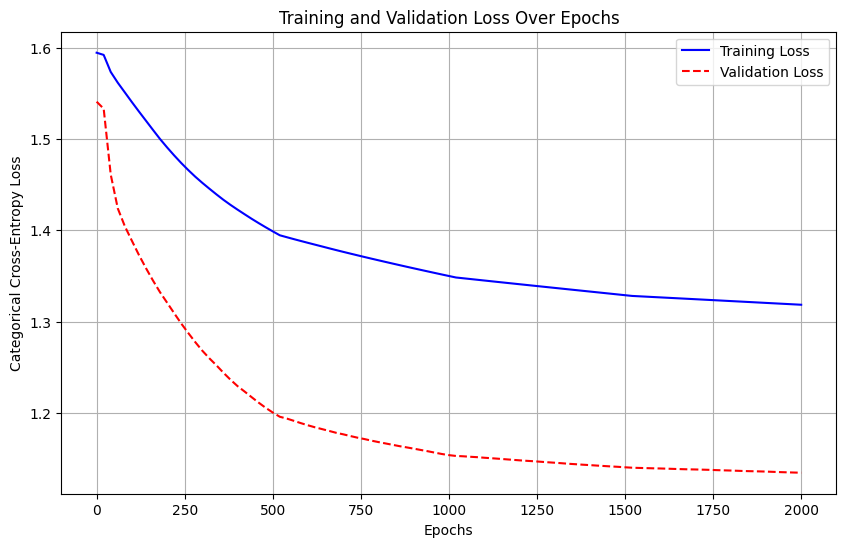

In [64]:
import matplotlib.pyplot as plt
# import numpy as np # Assumed imported

# 1. SETUP AND TRAINING CALL (Assuming X, Y, and train_val_split are defined)

# You must set these variables for the call:
EPOCHS = 2000  # Example value ###1500 gives accuracy of 0.5 with hidden dim = 10, learning rate = 0.05
LEARNING_RATE = 0.05 # Example value
HIDDEN_DIM = 150 # Example value
HIDDEN_DIM_2 = 50 # Example value``
LOG_INTERVAL = 20 # How often to record loss

# Initialize NN (using dimensions from the split data)
INPUT_DIM = X_train_augmented.shape[0]
OUTPUT_DIM = Y_train_augmented.shape[0]

nn = DeepNN(INPUT_DIM, HIDDEN_DIM, HIDDEN_DIM_2,  OUTPUT_DIM)

# Train the model and get the loss histories
train_loss, val_loss = nn.train(
    X_train_augmented, Y_train_augmented,
    X_val, Y_val,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    log_interval=LOG_INTERVAL
)

# 1. Use the length of the actual data returned by the training
actual_length = len(train_loss)

# 2. Generate indices based on that length
# This ensures x and y are always the same size, regardless of EPOCHS settings
epochs_to_plot = np.arange(actual_length) * LOG_INTERVAL

# 3. Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_plot, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_to_plot, val_loss, label='Validation Loss', color='red', linestyle='--')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.show()
# plt.savefig('loss_curve.png') # Use this if running in a non-interactive environment

In [65]:
# Predict on Training Set
train_preds = nn.predict(X_train_augmented)
# Convert Y_train from One-Hot (K, M) to Sparse (M,)
Y_train_sparse = np.argmax(Y_train_augmented, axis=0)
train_acc = np.mean(train_preds == Y_train_sparse)

# Predict on Validation Set
val_preds = nn.predict(X_val)
# Convert Y_val from One-Hot (K, M) to Sparse (M,)
Y_val_sparse = np.argmax(Y_val, axis=0)
val_acc = np.mean(val_preds == Y_val_sparse)

print(f"Training Accuracy:   {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

Training Accuracy:   45.62%
Validation Accuracy: 53.69%


Before, i got 0.48 and like 0.56 valid. This was nog exactly good. there was no set seed

    4: 115,  # Augment class 4 to 115
    1: 199,  # Augment class 1 to 199
    2: 250,  # Augment class 2 to 250
    3: 250,   # Augment class 3 to 250
    0: 400

    but results not reprocible. gave me 0.51 on kaggle test set.

    it was a bit better at classes 3 and 4 on valid set, but 1 worst on class 0, and shit for classes 0 and 4


In [66]:
from sklearn.metrics import confusion_matrix
import numpy as np


# 3. Calculate the Confusion Matrix
cm = confusion_matrix(Y_val_sparse, val_preds)

print("--- Confusion Matrix (NumPy Array) ---")
print(cm)

--- Confusion Matrix (NumPy Array) ---
[[87  0  9  8  0]
 [ 7  0  3  3  2]
 [17  0  5 15  1]
 [13  2  7 13  2]
 [ 2  0  1  2  4]]


In [67]:
import pickle

# Load the pickle file
with open('data/test_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Access images and labels
images_test = data['images']

In [68]:
# 1. Define the weights for R, G, B
rgb_weights = [0.299, 0.587, 0.114]
# This reduces the last dimension from 3 to 1
images_test = np.dot(images_test[..., :3], rgb_weights)

#images_test = np.mean(images_test, axis=3)



images_test = images_test.reshape(images_test.shape[0], -1)
images_test = images_test / 255.0
X_test = images_test.T  # Shape: (Features, Samples)


In [69]:
test_preds = nn.predict(X_test)
test_preds


array([0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 3, 0, 2, 0, 0, 0, 2, 2, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       3, 3, 0, 3, 2, 0, 0, 2, 2, 0, 0, 4, 4, 0, 0, 0, 1, 0, 3, 0, 0, 2,
       0, 2, 2, 2, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 3, 0, 3,
       3, 0, 0, 2, 0, 4, 4, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 0, 3, 0, 0, 0, 4, 4, 0, 0, 3, 0, 0, 0, 3, 4, 3, 0, 0, 0, 4,
       0, 2, 0, 0, 2, 0, 3, 4, 0, 0, 2, 0, 2, 4, 0, 2, 0, 0, 3, 0, 0, 0,
       3, 0, 2, 0, 3, 0, 0, 0, 0, 2, 0, 3, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 3, 3, 3, 0, 0, 2, 0, 2, 3,
       0, 0, 4, 0, 2, 0, 2, 2, 4, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 3,
       0, 2, 3, 0, 3, 3, 2, 0, 4, 0, 0, 2, 0, 0, 0, 0, 2, 3, 0, 3, 3, 2,
       0, 0, 0, 0, 0, 4, 3, 2, 4, 0, 3, 2, 0, 0, 3, 0, 0, 1, 3, 0, 2, 3,
       4, 2, 0, 0, 0, 0, 4, 3, 3, 3, 0, 0, 2, 0, 0, 4, 4, 2, 3, 2, 0, 3,
       2, 0, 0, 3, 0, 2, 2, 4, 0, 3, 0, 3, 0, 2, 0,

In [70]:
import pandas as pd
import numpy as np

# 1. Create the DataFrame
submission = pd.DataFrame({
    'ID': range(1, len(test_preds)+1), # Adjust to range(1, ...) if you need 1-based indexing
    'Label': test_preds
})


# 3. Export
submission.to_csv('data/submission.csv', index=False)

print("\n--- Raw File Preview (First 5 lines) ---")
with open('data/submission.csv', 'r') as f:
    for _ in range(5):
        print(f.readline().strip())


--- Raw File Preview (First 5 lines) ---
ID,Label
1,0
2,2
3,0
4,0


## Evaluate Models

Analyze your best model's performance (see README.md for evaluation guidelines).

In [22]:
####################################################################
###############   TO complete   ####################################
####################################################################

## Generate Predictions for Kaggle Submission

Create a CSV file with columns: `id` and `quality` (see README.md for format details).

In [ ]:

####################################################################
###############   TO complete   ####################################
####################################################################

---
Good luck with the competition! 🍺
